In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
from sentence_transformers import SentenceTransformer, util
import time
import torch
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import seaborn as sns

import lib.helper_pandas as hp



In [2]:
%%time
# @formatter:on

df = pd.read_parquet(path = './data/retail-transaction-clean-v1.parquet', engine = 'pyarrow')
n_rows = len(df.index)
n_cols = len(df.columns)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")

display(df.dtypes)
hp.unique_col_percent(df = df)
hp.null_val_summary(df = df)
df.head()



Dataframe length is: 528901
Number of columns is: 12


InvoiceNo                string
StockCode                string
Description              string
Quantity                  int64
InvoiceDate      datetime64[ns]
UnitPrice               float64
CustomerID                int64
Country                  string
InvoiceNoNum              int64
StockCodeNum              int64
StockCodeChar            string
TotalPrice              float64
dtype: object

InvoiceNo unique count and percentage: 20513, 3.88
StockCode unique count and percentage: 3805, 0.72
Description unique count and percentage: 4039, 0.76
Quantity unique count and percentage: 390, 0.07
InvoiceDate unique count and percentage: 18877, 3.57
UnitPrice unique count and percentage: 901, 0.17
CustomerID unique count and percentage: 4336, 0.82
Country unique count and percentage: 38, 0.01
InvoiceNoNum unique count and percentage: 20513, 3.88
StockCodeNum unique count and percentage: 3289, 0.62
StockCodeChar unique count and percentage: 28, 0.01
TotalPrice unique count and percentage: 4865, 0.92


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 2.62 s


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34


white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: Description, dtype: Int64

set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
set/3 red gingham rose storage box    482
ladies & gentlemen metal sign         482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: Description, dtype: Int64

wire flower t-light holder             1
letter "u" bling key ring              1
black glass/shell/pearl necklace       1
for online retail orders               1
cat with sunglasses blank card         1
small tahiti beach bag                 1
allocate stock for dotcom orders ta    1
wrongly sold (22719) barcode           1
blue new baroque flock candlestick     1
paper craft , little birdie            1
Name: Description, dtype: Int64

Wall time: 1.63 s


<BarContainer object of 20 artists>

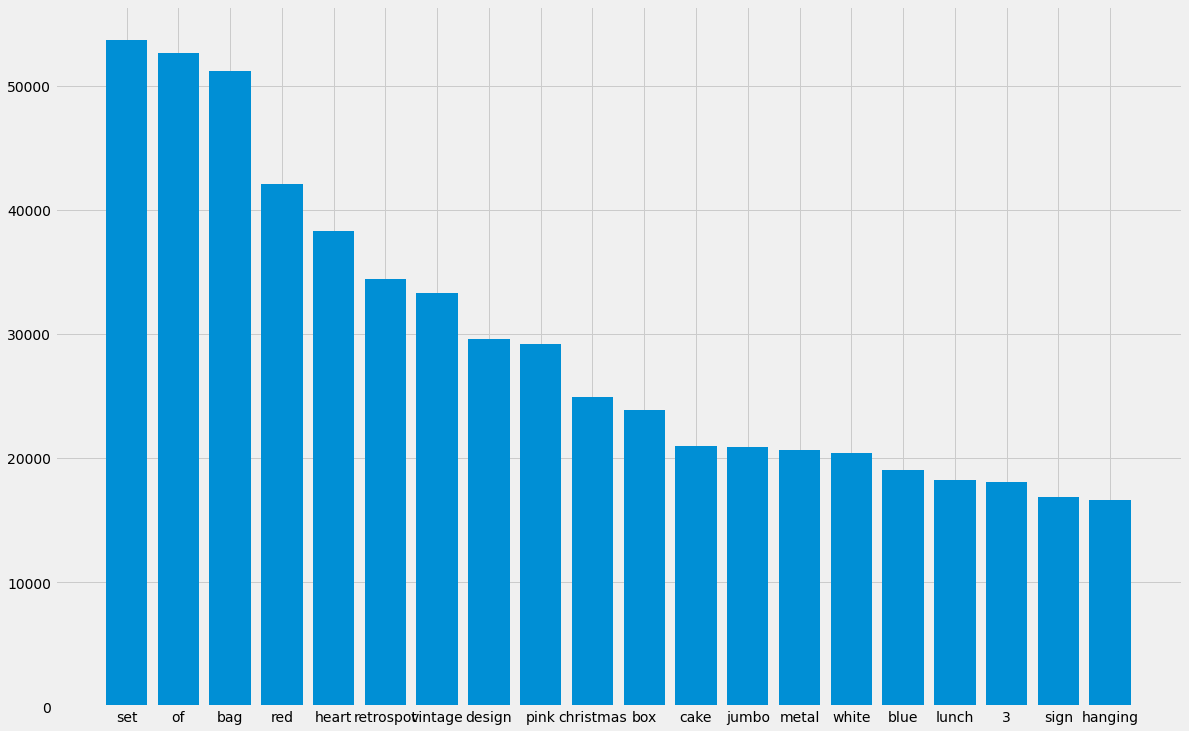

In [3]:
%%time
# @formatter:on

display(df['Description'].value_counts(dropna = False)[:10])
display(df['Description'].value_counts(dropna = False)[200:210])
display(df['Description'].value_counts(dropna = False)[-10:])

w = dict(Counter([i for j in df['Description'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (18, 12))
plt.bar(w.keys(), w.values())



In [4]:
%%time
# @formatter:on

# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy

def case_folder(text):
    return text.casefold()


df['DescriptionEdited'] = df['Description'].apply(lambda x: case_folder(x))
display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['Description'])])
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: DescriptionEdited, dtype: int64

set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
ladies & gentlemen metal sign         482
set/3 red gingham rose storage box    482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: DescriptionEdited, dtype: int64

jardin etched glass butter dish    1
vintage blue tinsel reel           1
pink bertie mobile phone charm     1
funky monkey mug                   1
bread bin, diner style, ivory      1
bread bin, diner style, mint       1
pink cherry lights                 1
blue crystal boot phone charm      1
happy birthday card teddy/cake     1
paper craft , little birdie        1
Name: DescriptionEdited, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited


unique values count: 4039
Wall time: 445 ms


In [5]:
%%time
# @formatter:on

# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.

def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_number(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set 7 babushka nesting boxes,set babushka nesting boxes
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of 6 assorted colour teaspoons,box of assorted colour teaspoons
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/2 red retrospot tea towels,set/ red retrospot tea towels
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of4 woodland,round snack boxes set of woodland
42,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,france,536370,22900,,70.80,set 2 tea towels i love london,set tea towels i love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528876,581585,22398,magnets pack of 4 swallows,12,2011-12-09 12:31:00,0.39,15804,united kingdom,581585,22398,,4.68,magnets pack of 4 swallows,magnets pack of swallows
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set 6 school milk bottles in crate,set school milk bottles in crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of 3 hanging owls ollie beak,set of hanging owls ollie beak
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack of 20 spaceboy napkins,pack of spaceboy napkins


unique values count: 3979
Wall time: 1.48 s


In [6]:
%%time
# @formatter:on

# removing possessive and verb s

def remove_possessive(text):
    return text.replace("'s", '')


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_possessive(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
11,536367,22745,poppy's playhouse bedroom,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22745,,12.60,poppy's playhouse bedroom,poppy playhouse bedroom
12,536367,22748,poppy's playhouse kitchen,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22748,,12.60,poppy's playhouse kitchen,poppy playhouse kitchen
45,536371,22086,paper chain kit 50's christmas,80,2010-12-01 09:00:00,2.55,13748,united kingdom,536371,22086,,204.00,paper chain kit 's christmas,paper chain kit christmas
116,536381,22086,paper chain kit 50's christmas,4,2010-12-01 09:41:00,2.95,15311,united kingdom,536381,22086,,11.80,paper chain kit 's christmas,paper chain kit christmas
373,536402,22086,paper chain kit 50's christmas,40,2010-12-01 11:22:00,2.55,15513,united kingdom,536402,22086,,102.00,paper chain kit 's christmas,paper chain kit christmas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528686,581538,23319,box of 6 mini 50's crackers,1,2011-12-09 11:34:00,2.49,14446,united kingdom,581538,23319,,2.49,box of mini 's crackers,box of mini crackers
528804,581579,22086,paper chain kit 50's christmas,12,2011-12-09 12:19:00,2.95,17581,united kingdom,581579,22086,,35.40,paper chain kit 's christmas,paper chain kit christmas
528807,581579,23319,box of 6 mini 50's crackers,12,2011-12-09 12:19:00,2.49,17581,united kingdom,581579,23319,,29.88,box of mini 's crackers,box of mini crackers
528825,581579,23344,jumbo bag 50's christmas,20,2011-12-09 12:19:00,1.79,17581,united kingdom,581579,23344,,35.80,jumbo bag 's christmas,jumbo bag christmas


unique values count: 3979
Wall time: 424 ms


In [7]:
%%time
# @formatter:on

# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", "", text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_special_char(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
lunch bag red retrospot              1594
assorted colour bird ornament        1489
french blue metal door sign          1488
set of  cake tins pantry design      1401
pack of  retrospot cake cases        1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set of  wooden heart decorations    487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies  gentlemen metal sign        482
feltcraft cushion owl               481
set  colour pencils spaceboy        481
Name: DescriptionEditedTemp, dtype: int64

pink acrylic jewel snowflake       1
green pendant shell necklace       1
happy birthday card teddycake      1
filigree diamante chain            1
blossom images scrap book set      1
mint diner clock                   1
curious images scrap book set      1
pink painted kashmiri chair        1
blue gingham rose cushion cover    1
paper craft  little birdie         1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart.,red woolly hottie white heart
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,united kingdom,536365,21730,,25.50,glass star frosted t-light holder,glass star frosted tlight holder
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/ red retrospot tea towels,set red retrospot tea towels
48,536373,85123a,white hanging heart t-light holder,6,2010-12-01 09:02:00,2.55,17850,united kingdom,536373,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528859,581584,85038,6 chocolate love heart t-lights,48,2011-12-09 12:25:00,1.85,13777,united kingdom,581584,85038,,88.80,chocolate love heart t-lights,chocolate love heart tlights
528861,581585,84945,multi colour silver t-light holder,24,2011-12-09 12:31:00,0.85,15804,united kingdom,581585,84945,,20.40,multi colour silver t-light holder,multi colour silver tlight holder
528864,581585,22178,victorian glass hanging t-light,12,2011-12-09 12:31:00,1.95,15804,united kingdom,581585,22178,,23.40,victorian glass hanging t-light,victorian glass hanging tlight
528875,581585,84946,antique silver t-light glass,12,2011-12-09 12:31:00,1.25,15804,united kingdom,581585,84946,,15.00,antique silver t-light glass,antique silver tlight glass


unique values count: 3969
Wall time: 1.03 s


In [8]:
%%time
# @formatter:on

# removing words with less than 3 character

def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_short_word(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set   cake tins pantry design        1401
pack   retrospot cake cases          1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

pantry magnetic  shopping list      489
jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set   wooden heart decorations      487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies  gentlemen metal sign        482
set red gingham rose storage box    482
set  colour pencils spaceboy        481
Name: DescriptionEditedTemp, dtype: int64

glass bead hoop necklace black        1
baroque butterfly earrings montana    1
zinc plant pot holder                 1
zinc star tlight holder               1
incorrectly credited  see             1
capiz chandelier                      1
  cutlery set pantry design           1
lily brooch whitesilver colour        1
pearl  shell neckl ivory              1
paper craft  little birdie            1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box of vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box of vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of woodland,round snack boxes set woodland
36,536370,22659,lunch box i love london,24,2010-12-01 08:45:00,1.95,12583,france,536370,22659,,46.80,lunch box i love london,lunch box love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set school milk bottles in crate,set school milk bottles crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters in tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters in tin circus parade,plasters tin circus parade


unique values count: 3936
Wall time: 1.23 s


In [9]:
%%time
# @formatter:on

# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_extra_whitespace_tabs(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink painted kashmiri chair            1
fire polished glass neckl gold         1
pink marshmallow scarf knitting kit    1
acrylic jewel snowflakepink            1
vintage bead pink jewel stand          1
keep out girls door hanger             1
opulent velvet set candles             1
miseltoe heart wreath cream            1
doorknob ceramic ivory                 1
paper craft little birdie              1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set babushka nesting boxes,set babushka nesting boxes
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set woodland,round snack boxes set woodland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters tin circus parade,plasters tin circus parade
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkins


unique values count: 3922
Wall time: 1.83 s


In [10]:
%%time
# @formatter:on

display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEdited, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEdited, dtype: int64

pink painted kashmiri chair            1
fire polished glass neckl gold         1
pink marshmallow scarf knitting kit    1
acrylic jewel snowflakepink            1
vintage bead pink jewel stand          1
keep out girls door hanger             1
opulent velvet set candles             1
miseltoe heart wreath cream            1
doorknob ceramic ivory                 1
paper craft little birdie              1
Name: DescriptionEdited, dtype: int64

Wall time: 177 ms


In [11]:
%%time
# @formatter:on

# python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable = ['parser', 'ner'])
print(nlp.pipe_names)



['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']
Wall time: 1.21 s


In [12]:
%%time
# @formatter:on

unique_desc = list(df['DescriptionEdited'].unique())

# New stop words list
customized_stop_words = [
    'alice blue', 'antique white',
    'aqua', 'aquamarine',
    'azure', 'beige',
    'bisque', 'black',
    'blanched almond', 'blue',
    'blue violet', 'brown',
    'burly wood', 'cadet blue',
    'chartreuse', 'chocolate',
    'coral', 'cornflower blue',
    'cornsilk', 'crimson',
    'cyan', 'dark blue',
    'dark cyan', 'dark golden rod',
    'dark gray', 'dark grey',
    'dark green', 'dark khaki',
    'dark magenta', 'dark olive green',
    'dark orange', 'dark orchid',
    'dark red', 'dark salmon',
    'dark sea green', 'dark slate blue',
    'dark slate gray', 'dark slate grey',
    'dark turquoise', 'dark violet',
    'deep pink', 'deep sky blue',
    'dim gray', 'dim grey',
    'dodger blue', 'fire brick',
    'floral white', 'forest green',
    'fuchsia', 'gainsboro',
    'ghost white', 'gold',
    'golden rod', 'gray',
    'grey', 'green',
    'green yellow', 'honey dew',
    'hot pink', 'indian red',
    'indigo', 'ivory',
    'khaki', 'lavender',
    'lavender blush', 'lawn green',
    'lemon chiffon', 'light blue',
    'light coral', 'light cyan',
    'light golden rod yellow',
    'light gray', 'light grey',
    'light green', 'light pink',
    'light salmon', 'light sea green',
    'light sky blue', 'light slate gray',
    'light slate grey', 'light steel blue',
    'light yellow', 'lime',
    'lime green', 'linen',
    'magenta', 'maroon',
    'medium aqua marine', 'medium blue',
    'medium orchid', 'medium purple',
    'medium sea green', 'medium slate blue',
    'medium spring green', 'medium turquoise',
    'medium violet red', 'midnight blue',
    'mint cream', 'misty rose', 'moccasin',
    'navajo white', 'navy',
    'old lace', 'olive',
    'olive drab', 'orange',
    'orange red', 'orchid',
    'pale golden rod', 'pale green',
    'pale turquoise', 'pale violet red',
    'papaya whip', 'peach puff',
    'peru', 'pink',
    'plum', 'powder blue',
    'purple', 'rebecca purple',
    'red', 'rosy brown',
    'royal blue', 'saddle brown',
    'salmon', 'sandy brown',
    'sea green', 'sea shell',
    'sienna', 'sky blue',
    'slate blue', 'slate gray',
    'slate grey', 'snow',
    'spring green', 'steel blue',
    'tan', 'teal',
    'thistle', 'tomato',
    'turquoise', 'violet',
    'wheat', 'white',
    'white smoke', 'yellow',
    'yellow green',

    #, 'silver'
    'set',

    'medium',
    'small', 'large',
    'giant',

    'wrongly code',
    'mark as',
    'wrongly mark'
]

# Mark them as stop words
for w in customized_stop_words:
    nlp.vocab[w].is_stop = True

res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process = 2)):
    res.append(" ".join(token.lemma_ for token in doc if not token.is_stop))

for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['DescriptionEdited'] == item].index, 'DescriptionEditedTemp'] = res[inx]

display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



3922it [00:11, 329.50it/s] 
100%|██████████| 3922/3922 [04:04<00:00, 16.06it/s]


alarm clock bakelike        4340
heart wicker                3409
hang heart tlight holder    3163
jumbo bag retrospot         2115
regency cakestand tier      2019
regency teacup saucer       1837
party bunting               1707
french metal door sign      1653
lunch bag retrospot         1594
spot ceramic drawer knob    1552
Name: DescriptionEditedTemp, dtype: int64

cream heart card holder        531
kids cookie cutter             531
suki shoulder bag              531
spaceboy birthday card         530
plaster tin strongman          530
pack london tissue             529
cream sweetheart mini chest    529
airline bag vintage jet        528
jumbo bag toy                  525
assorted colour silk fan       519
Name: DescriptionEditedTemp, dtype: int64

bell heart antique                     1
gardener kneel pad                     1
country cottage doorstop               1
watering single hook pistachio         1
disco partition panel                  1
christmas table candle silver spike    1
wrap flock                             1
weekend bag vintage rise paisley       1
jardin etch glass butter dish          1
paper craft little birdie              1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart tlight holder,hang heart tlight holder
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34,white metal lantern,metal lantern
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00,cream cupid hearts coat hanger,cream cupid heart coat hanger
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34,knitted union flag hot water bottle,knit union flag hot water bottle
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart,woolly hottie heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528892,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680,france,581587,22730,,15.00,alarm clock bakelike ivory,alarm clock bakelike
528894,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,france,581587,22899,,12.60,children apron dolly girl,child apron dolly girl
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkin
528898,581587,23256,childrens cutlery spaceboy,4,2011-12-09 12:50:00,4.15,12680,france,581587,23256,,16.60,childrens cutlery spaceboy,children cutlery spaceboy


unique values count: 3461
Wall time: 4min 16s


Wall time: 1.29 s


<BarContainer object of 20 artists>

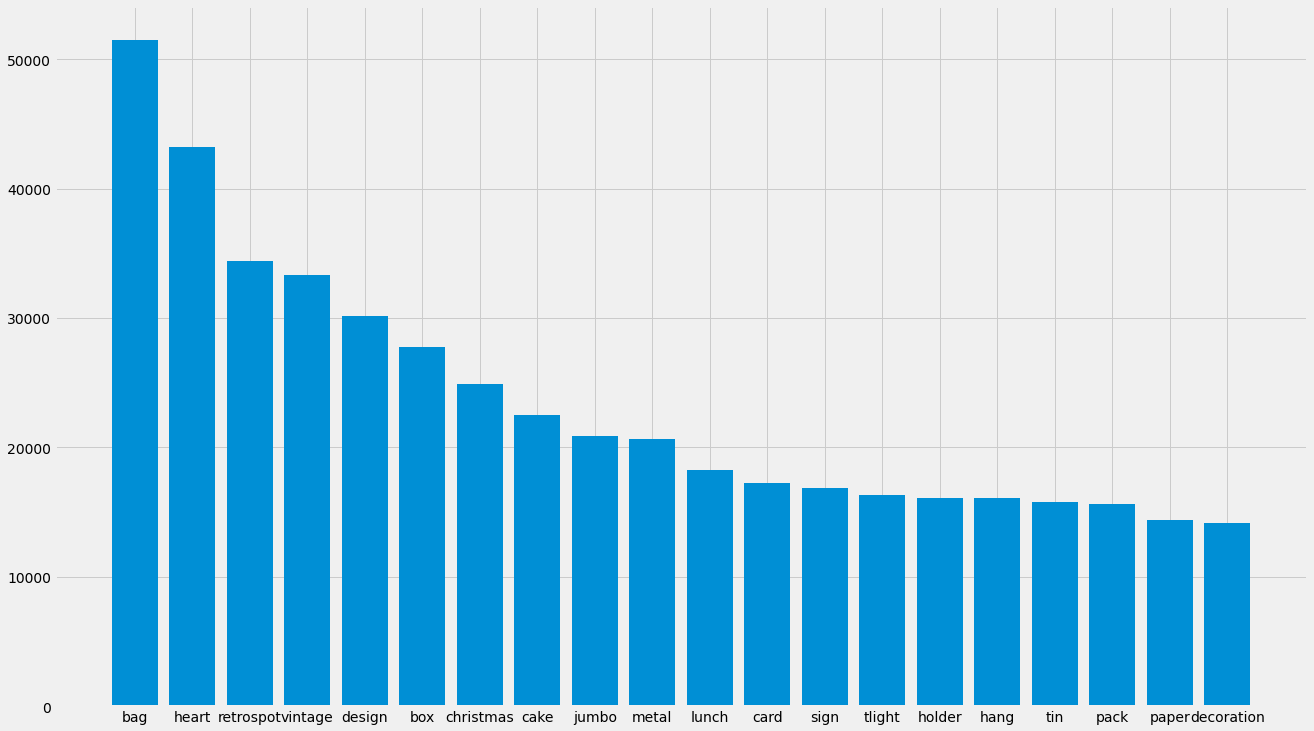

In [13]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())



{'allocate': 2, 'online': 2, 'find': 2, 'waterpump': 2, 'poinsettia': 2, 'minicard': 2, 'necklaceleaf': 2, 'amazon': 2, 'silt': 2, 'squ': 2, 'crome': 2, 'candleincense': 2, 'deck': 2, 'girly': 1, 'loveheart': 1, 'tinsel': 1, 'weekend': 1, 'blackchristmas': 1, 'boombox': 1, 'ipod': 1, 'demi': 1, 'choker': 1, 'opulent': 1, 'snowflakepink': 1, 'banner': 1, 'cutglass': 1, 'ooh': 1, 'bazaar': 1, 'bluenat': 1, 'scallop': 1, 'heavens': 1, 'fragrance': 1, 'purpleturq': 1, 'sell': 1, 'barcode': 1, 'rcvd': 1, 'temp': 1, 'flowerbutterfly': 1, 'mummy': 1, 'tick': 1, 'ret': 1, 'orangefuschia': 1, 'antoienett': 1, 'laser': 1, 'haynes': 1, 'camper': 1, 'whitesilver': 1, 'capiz': 1, 'incorrectly': 1, 'alan': 1, 'hodge': 1, 'mamage': 1, 'section': 1, 'beadshand': 1, 'fba': 1, 'teddycake': 1, 'add': 1, 'retail': 1, 'damage': 1, 'whse': 1, 'website': 1, 'draw': 1, 'trading': 1, 'zero': 1, 'invc': 1, 'incorr': 1, 'michel': 1, 'oops': 1, 'artonly': 1, 'partition': 1, 'panel': 1, 'sale': 1, 'error': 1, 'mir

<BarContainer object of 15 artists>

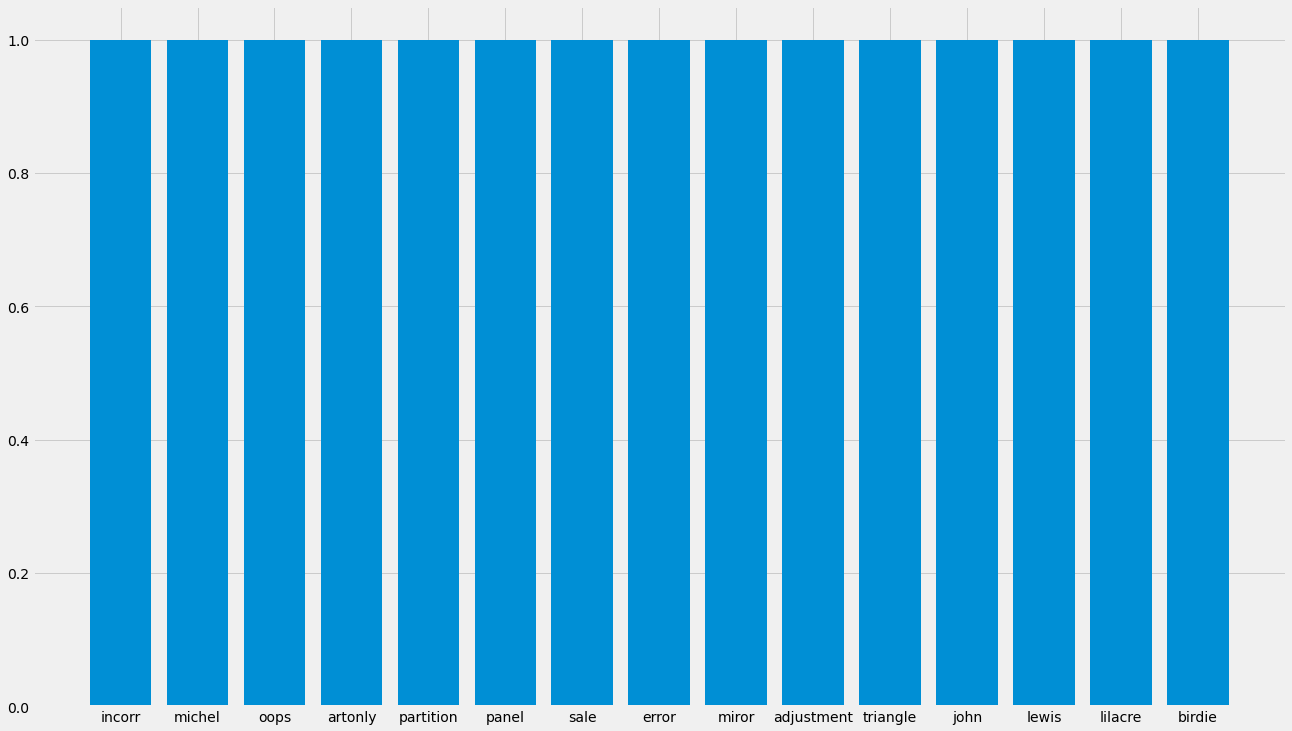

In [14]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-80:])
print(w)
w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-15:])
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())

In [15]:
%%time
# @formatter:on
# cluster same idproducts together.


Wall time: 0 ns


In [16]:
%%time
# @formatter:on

model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')
unique_corpus_sentences = list(df['DescriptionEdited'].unique())
corpus_embeddings = model.encode(unique_corpus_sentences,
                                 batch_size = 64,
                                 show_progress_bar = True,
                                 convert_to_tensor = True)

print("Start clustering")
start_time = time.time()
# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least min_cluster_size elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
detected_clusters = util.community_detection(corpus_embeddings,
                                             min_community_size = 2,
                                             threshold = 0.85, )
print(f"Clustering done after {time.time() - start_time:.2f} sec")
print(f"Number of clusters: {len(detected_clusters)}")

for i, cluster in enumerate(detected_clusters):
    if i % 30 == 0:
        # The first element in each list is the central point in the community.
        print(f"Cluster {i + 1}, #{len(cluster)} Elements")
        for sentence_id in cluster[0:2]:
            print("\t", unique_corpus_sentences[sentence_id])



Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.33 sec
Number of clusters: 382
Cluster 1, #9 Elements
	 embroidered ribbon reel rebecca
	 embroidered ribbon reel rachel
Cluster 31, #4 Elements
	 christmas tree star decoration
	 christmas star decoration
Cluster 61, #3 Elements
	 yuletide image gift wrap
	 curious image gift wrap
Cluster 91, #3 Elements
	 bell heart decoration
	 jingle bell heart decoration
Cluster 121, #2 Elements
	 retrospot mug
	 retrospot mug box
Cluster 151, #2 Elements
	 wooden advent calendar
	 wooden box advent calendar
Cluster 181, #2 Elements
	 wooden tree christmas scandinavian
	 wooden star christmas scandinavian
Cluster 211, #2 Elements
	 feel farm animal bunny
	 feel farm animal rabbit
Cluster 241, #2 Elements
	 jewelled mirror trinket tray
	 silver jewelled mirror trinket tray
Cluster 271, #2 Elements
	 mirror mosaic tlight holder
	 mirror mosaic tlight holder round
Cluster 301, #2 Elements
	 crochet bear redblue keyring
	 crochet lilacre bear keyring
Cluster 33

In [17]:
%%time
# @formatter:on

cluster_centers_embeddings = []
for i, cluster in enumerate(detected_clusters):
    cluster_unique_sentences = []
    cluster_centers_embeddings.append(corpus_embeddings[cluster[0]])
    for sentence_id in cluster:
        cluster_unique_sentences.append(unique_corpus_sentences[sentence_id])
    df.loc[df[df['DescriptionEdited'].isin(cluster_unique_sentences)].index, 'ClusterId'] = i

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,393547
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.408443


Total Quantity of unclustered sales: 4354848, percentage: 77.17
Total Quantity*UnitPrice of unclustered sales: 7716274.92, percentage: 73.86
Wall time: 8.62 s


In [18]:
%%time
# @formatter:on

df['StockCodeNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['StockCodeNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,NaN,79823,155556.869231
217522,556481,23166,medium ceramic top storage jar,3,2011-06-12 13:00:00,1.25,16115,united kingdom,556481,23166,,3.75,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
396486,571844,22197,popcorn holder,24,2011-10-19 12:30:00,0.85,17101,united kingdom,571844,22197,,20.40,popcorn holder,popcorn holder,NaN,56921,51354.020000
14044,537489,84077,world war 2 gliders asstd designs,48,2010-12-07 11:33:00,0.29,17017,united kingdom,537489,84077,,13.92,world war glider asstd design,world war glider asstd design,NaN,55047,13841.850000
506555,580136,85123a,white hanging heart t-light holder,6,2011-12-01 19:42:00,2.95,17841,united kingdom,580136,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778
127562,547511,84879,assorted colour bird ornament,8,2011-03-23 13:44:00,1.69,17411,united kingdom,547511,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,NaN,36461,59094.930000
160491,550673,21212,pack of 72 retrospot cake cases,24,2011-04-20 10:28:00,0.55,12971,united kingdom,550673,21212,,13.20,pack retrospot cake case,pack retrospot cake case,NaN,36419,21259.100000
224284,557132,23084,rabbit night light,12,2011-06-17 08:57:00,2.08,13107,united kingdom,557132,23084,,24.96,rabbit night light,rabbit night light,NaN,31722,70012.943333
273486,561507,22492,mini paint set vintage,36,2011-07-27 14:21:00,0.65,12397,belgium,561507,22492,,23.40,mini paint vintage,mini paint vintage,NaN,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
352175,568346,22423,regency cakestand 3 tier,1,2011-09-26 15:28:00,24.96,14096,united kingdom,568346,22423,,24.96,regency cakestand tier,regency cakestand tier,28.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
121591,546986,85099f,jumbo bag strawberry,10,2011-03-18 12:56:00,1.95,14194,united kingdom,546986,85099,f,19.50,jumbo bag strawberry,jumbo bag strawberry,NaN,79823,155556.869231
174387,552262,85123a,white hanging heart t-light holder,6,2011-05-08 11:37:00,2.95,14911,eire,552262,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778
199860,554756,47566,party bunting,8,2011-05-26 11:36:00,4.95,16837,united kingdom,554756,47566,,39.60,party bunting,party bunting,NaN,22180,122142.144000
475473,577772,23166,medium ceramic top storage jar,48,2011-11-21 15:53:00,1.04,18139,united kingdom,577772,23166,,49.92,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
495577,579188,23084,rabbit night light,18,2011-11-28 15:34:00,2.08,12748,united kingdom,579188,23084,,37.44,rabbit night light,rabbit night light,NaN,31722,70012.943333
418972,573576,84997a,childrens cutlery polkadot green,1,2011-10-31 14:09:00,8.29,14096,united kingdom,573576,84997,a,8.29,children cutlery polkadot,children cutlery polkadot,108.0,16749,69181.420000
481095,578225,22086,paper chain kit 50's christmas,6,2011-11-23 11:51:00,2.95,17700,united kingdom,578225,22086,,17.70,paper chain kit christmas,paper chain kit christmas,104.0,19355,64952.290000
24663,538361,22502,picnic basket wicker small,2,2010-12-10 16:36:00,5.95,17757,united kingdom,538361,22502,,11.90,picnic basket wicker,picnic basket wicker,118.0,2048,60861.770000


Wall time: 1.28 s


In [19]:
%%time
# @formatter:on

stacked_centers_embeddings = torch.stack(cluster_centers_embeddings)
# average over cluster
unclustered_df = df[df['ClusterId'].isna()]
unclustered_embeddings = torch.stack(unclustered_df['DescriptionEdited'].apply(lambda x:
                                                                               corpus_embeddings[unique_corpus_sentences.index(x)]).tolist())
df.loc[unclustered_df.index, 'ClusterId'] = torch.argmax(util.cos_sim(unclustered_embeddings, stacked_centers_embeddings), dim = 1).numpy()

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Quantity of unclustered sales: 0, percentage: 0.00
Total Quantity*UnitPrice of unclustered sales: 0.00, percentage: 0.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,2.0,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,130.0,79823,155556.869231
217522,556481,23166,medium ceramic top storage jar,3,2011-06-12 13:00:00,1.25,16115,united kingdom,556481,23166,,3.75,ceramic storage jar,ceramic storage jar,322.0,78033,81700.920000
396486,571844,22197,popcorn holder,24,2011-10-19 12:30:00,0.85,17101,united kingdom,571844,22197,,20.40,popcorn holder,popcorn holder,321.0,56921,51354.020000
14044,537489,84077,world war 2 gliders asstd designs,48,2010-12-07 11:33:00,0.29,17017,united kingdom,537489,84077,,13.92,world war glider asstd design,world war glider asstd design,268.0,55047,13841.850000
506555,580136,85123a,white hanging heart t-light holder,6,2011-12-01 19:42:00,2.95,17841,united kingdom,580136,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778
127562,547511,84879,assorted colour bird ornament,8,2011-03-23 13:44:00,1.69,17411,united kingdom,547511,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,144.0,36461,59094.930000
160491,550673,21212,pack of 72 retrospot cake cases,24,2011-04-20 10:28:00,0.55,12971,united kingdom,550673,21212,,13.20,pack retrospot cake case,pack retrospot cake case,173.0,36419,21259.100000
224284,557132,23084,rabbit night light,12,2011-06-17 08:57:00,2.08,13107,united kingdom,557132,23084,,24.96,rabbit night light,rabbit night light,83.0,31722,70012.943333
273486,561507,22492,mini paint set vintage,36,2011-07-27 14:21:00,0.65,12397,belgium,561507,22492,,23.40,mini paint vintage,mini paint vintage,211.0,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
352175,568346,22423,regency cakestand 3 tier,1,2011-09-26 15:28:00,24.96,14096,united kingdom,568346,22423,,24.96,regency cakestand tier,regency cakestand tier,28.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,2.0,80995,168469.600000
121591,546986,85099f,jumbo bag strawberry,10,2011-03-18 12:56:00,1.95,14194,united kingdom,546986,85099,f,19.50,jumbo bag strawberry,jumbo bag strawberry,130.0,79823,155556.869231
174387,552262,85123a,white hanging heart t-light holder,6,2011-05-08 11:37:00,2.95,14911,eire,552262,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778
199860,554756,47566,party bunting,8,2011-05-26 11:36:00,4.95,16837,united kingdom,554756,47566,,39.60,party bunting,party bunting,141.0,22180,122142.144000
475473,577772,23166,medium ceramic top storage jar,48,2011-11-21 15:53:00,1.04,18139,united kingdom,577772,23166,,49.92,ceramic storage jar,ceramic storage jar,322.0,78033,81700.920000
495577,579188,23084,rabbit night light,18,2011-11-28 15:34:00,2.08,12748,united kingdom,579188,23084,,37.44,rabbit night light,rabbit night light,83.0,31722,70012.943333
418972,573576,84997a,childrens cutlery polkadot green,1,2011-10-31 14:09:00,8.29,14096,united kingdom,573576,84997,a,8.29,children cutlery polkadot,children cutlery polkadot,108.0,16749,69181.420000
481095,578225,22086,paper chain kit 50's christmas,6,2011-11-23 11:51:00,2.95,17700,united kingdom,578225,22086,,17.70,paper chain kit christmas,paper chain kit christmas,104.0,19355,64952.290000
24663,538361,22502,picnic basket wicker small,2,2010-12-10 16:36:00,5.95,17757,united kingdom,538361,22502,,11.90,picnic basket wicker,picnic basket wicker,118.0,2048,60861.770000


Wall time: 11.3 s


In [20]:
%%time
# @formatter:on

df['ClusterIdQuantitySum'] = df.groupby('ClusterId')['Quantity'].transform(sum)
df['ClusterIdTotalPriceSum'] = df.groupby('ClusterId')['TotalPrice'].transform(sum)

# top cluster seller
display(df.sort_values(by = ['ClusterIdQuantitySum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))
display(df.sort_values(by = ['ClusterIdTotalPriceSum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
287462,562775,23203,jumbo bag vintage doiley,20,2011-08-09 12:21:00,2.08,15078,united kingdom,562775,23203,,41.60,jumbo bag vintage doiley,jumbo bag vintage doiley,37.0,20603,42329.208571,135357,291379.646291
492440,578995,22379,recycling bag retrospot,2,2011-11-27 15:59:00,2.10,15861,united kingdom,578995,22379,,4.20,recycle bag retrospot,recycle bag retrospot,184.0,6910,15636.990000,120087,233483.368731
206851,555477,23182,toilet sign occupied or vacant,24,2011-06-03 12:26:00,0.83,12359,cyprus,555477,23182,,19.92,toilet sign occupy vacant,toilet sign occupy vacant,27.0,3777,3718.090000,114491,220377.437606
510088,580468,23329,decorative wicker heart large,2,2011-12-04 12:31:00,1.65,12748,united kingdom,580468,23329,,3.30,decorative wicker heart,decorative wicker heart,65.0,1778,3056.340000,99308,165433.007727
472997,577549,22189,cream heart card holder,1,2011-11-20 15:00:00,3.95,17841,united kingdom,577549,22189,,3.95,cream heart card holder,cream heart card holder,137.0,8291,23463.470000,96377,84119.412000
133602,548011,22780,light garland butterfiles pink,48,2011-03-29 11:14:00,3.75,14646,netherlands,548011,22780,,180.00,light garland butterfile,light garland butterfile,2.0,1346,5044.340000,96079,190847.675000
53454,540977,20801,large pink glass sundae dish,9,2011-01-12 15:01:00,2.51,-1,united kingdom,540977,20801,,22.59,glass sundae dish,glass sundae dish,322.0,1019,1174.154286,95158,116266.400952
87788,543985,21980,pack of 12 red retrospot tissues,2,2011-02-15 09:44:00,0.83,-1,united kingdom,543985,21980,,1.66,pack retrospot tissue,pack retrospot tissue,152.0,6687,2121.760000,87337,34442.150000
195040,554117,85123a,white hanging heart t-light holder,32,2011-05-22 15:12:00,2.55,13758,united kingdom,554117,85123,a,81.60,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778,77096,170029.468889
353786,568533,23293,set of 12 fairy cake baking cases,64,2011-09-27 13:56:00,0.72,15061,united kingdom,568533,23293,,46.08,fairy cake baking case,fairy cake baking case,79.0,8486,7001.990000,76535,78982.836667


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
293482,563256,23199,jumbo bag apples,10,2011-08-15 12:07:00,2.08,18143,united kingdom,563256,23199,,20.80,jumbo bag apple,jumbo bag apple,37.0,14920,30475.650000,135357,291379.646291
287721,562789,21481,fawn blue hot water bottle,36,2011-08-09 13:50:00,2.55,14646,netherlands,562789,21481,,91.80,fawn hot water bottle,fawn hot water bottle,14.0,3314,11472.168182,50115,244575.415101
357532,568798,85099b,jumbo bag red retrospot,10,2011-09-29 10:23:00,2.08,12615,france,568798,85099,b,20.80,jumbo bag retrospot,jumbo bag retrospot,184.0,79823,155556.869231,120087,233483.368731
59185,541422,22222,cake plate lovebird white,8,2011-01-17 17:48:00,4.13,-1,united kingdom,541422,22222,,33.04,cake plate lovebird,cake plate lovebird,28.0,1057,3880.200000,23786,229648.940127
315527,565378,82583,hot baths metal sign,10,2011-09-02 15:16:00,4.96,-1,united kingdom,565378,82583,,49.60,hot bath metal sign,hot bath metal sign,27.0,7562,17879.292727,114491,220377.437606
131415,547867,22938,cupcake lace paper set 6,3,2011-03-27 13:56:00,1.95,13357,united kingdom,547867,22938,,5.85,cupcake lace paper,cupcake lace paper,141.0,2367,4488.630000,61777,205529.856500
382762,570726,23233,wrap poppies design,25,2011-10-12 11:32:00,0.42,16607,united kingdom,570726,23233,,10.50,wrap poppy design,wrap poppy design,2.0,5175,2105.500000,96079,190847.675000
85398,543664,22192,blue diner wall clock,2,2011-02-11 10:57:00,8.50,17705,united kingdom,543664,22192,,17.00,diner wall clock,diner wall clock,96.0,954,8189.290000,38841,184274.091357
205673,555349,85123a,white hanging heart t-light holder,2,2011-06-02 12:08:00,2.95,16729,united kingdom,555349,85123,a,5.90,hang heart tlight holder,hang heart tlight holder,8.0,41956,124017.697778,77096,170029.468889
428324,574476,23333,ivory wicker heart medium,2,2011-11-04 12:20:00,1.25,17203,united kingdom,574476,23333,,2.50,wicker heart,wicker heart,65.0,2110,2721.700000,99308,165433.007727


Wall time: 1.08 s


In [21]:
%%time
# @formatter:on

clusters_center_df = pd.DataFrame()
for cluster_id, df_cluster in df.groupby(['ClusterId']):
    clusters_center_df = clusters_center_df.append({'Id': int(cluster_id),
                                                    'Center': corpus_embeddings[detected_clusters[int(cluster_id)][0]].numpy(),
                                                    'CommonWords': ' '.join(
                                                        list(dict(Counter([i for j in df_cluster['DescriptionEdited'].str.split().tolist()
                                                                           for i in j]).most_common(5)).keys()))},
                                                   ignore_index = True)
    if cluster_id % 50 == 0:
        display(df_cluster.drop_duplicates(subset = ['DescriptionEdited']))

clusters_center_df.to_parquet(path = './data/product-clustered-center-v1.parquet', engine = 'pyarrow')
# df1 = pd.read_parquet(path = './data/retail-products-clusters-v1.parquet', engine = 'pyarrow')
# df1['Center'] = df1['Center'].apply(lambda x: torch.from_numpy(x))

df = df.drop(columns = ['DescriptionEditedTemp'])
df.to_parquet(path = './data/transaction-clustered-v1.parquet', engine = 'pyarrow')



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
236,536392,21891,traditional wooden skipping rope,12,2010-12-01 10:29:00,1.25,13705,united kingdom,536392,21891,,15.00,traditional wooden skipping rope,traditional wooden skipping rope,0.0,8146,10527.625,24983,43721.61
464,536408,22736,ribbon reel making snowmen,10,2010-12-01 11:41:00,1.65,14307,united kingdom,536408,22736,,16.50,ribbon reel make snowman,ribbon reel make snowman,0.0,1233,2315.250,24983,43721.61
617,536415,22738,ribbon reel snowy village,3,2010-12-01 11:57:00,1.65,12838,united kingdom,536415,22738,,4.95,ribbon reel snowy village,ribbon reel snowy village,0.0,2189,3856.070,24983,43721.61
779,536464,22737,ribbon reel christmas present,1,2010-12-01 12:23:00,1.65,17968,united kingdom,536464,22737,,1.65,ribbon reel christmas present,ribbon reel christmas present,0.0,1389,2695.800,24983,43721.61
834,536464,22082,ribbon reel stripes design,5,2010-12-01 12:23:00,1.65,17968,united kingdom,536464,22082,,8.25,ribbon reel stripe design,ribbon reel stripe design,0.0,2713,4716.330,24983,43721.61
1482,536544,22080,ribbon reel polkadots,1,2010-12-01 14:32:00,3.36,-1,united kingdom,536544,22080,,3.36,ribbon reel polkadot,ribbon reel polkadot,0.0,1222,2031.245,24983,43721.61
1483,536544,22081,ribbon reel flora + fauna,1,2010-12-01 14:32:00,3.36,-1,united kingdom,536544,22081,,3.36,ribbon reel flora fauna,ribbon reel flora fauna,0.0,654,1193.000,24983,43721.61
2596,536592,22078,ribbon reel lace design,1,2010-12-01 17:06:00,4.21,-1,united kingdom,536592,22078,,4.21,ribbon reel lace design,ribbon reel lace design,0.0,1385,2962.950,24983,43721.61
4526,536796,21268,vintage blue tinsel reel,2,2010-12-02 15:46:00,0.42,15574,united kingdom,536796,21268,,0.84,vintage tinsel reel,vintage tinsel reel,0.0,2,0.840,24983,43721.61
7456,537047,22079,ribbon reel hearts design,1,2010-12-05 11:02:00,1.65,13069,united kingdom,537047,22079,,1.65,ribbon reel heart design,ribbon reel heart design,0.0,1911,3348.390,24983,43721.61


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
738,536446,84836,zinc metal heart decoration,12,2010-12-01 12:15:00,1.25,15983,united kingdom,536446,84836,,15.00,zinc metal heart decoration,zinc metal heart decoration,50.0,5944,7426.8200,13868,14432.1475
1536,536544,22335,heart decoration painted zinc,4,2010-12-01 14:32:00,1.28,-1,united kingdom,536544,22335,,5.12,heart decoration paint zinc,heart decoration paint zinc,50.0,2386,1672.7900,13868,14432.1475
2903,536592,84459b,yellow metal chicken heart,1,2010-12-01 17:06:00,3.36,-1,united kingdom,536592,84459,b,3.36,metal chicken heart,metal chicken heart,50.0,1455,2179.2475,13868,14432.1475
68536,541999,22597,musical zinc heart decoration,3,2011-01-25 10:45:00,1.63,-1,united kingdom,541999,22597,,4.89,musical zinc heart decoration,musical zinc heart decoration,50.0,2822,1247.7800,13868,14432.1475
73774,542607,20851,zinc heart lattice tray oval,2,2011-01-30 13:48:00,5.95,13148,united kingdom,542607,20851,,11.90,zinc heart lattice tray oval,zinc heart lattice tray oval,50.0,10,59.5000,13868,14432.1475
180531,552813,23068,aluminium heart,4,2011-05-11 12:44:00,2.49,15079,united kingdom,552813,23068,,9.96,aluminium heart,aluminium heart,50.0,813,1976.8900,13868,14432.1475
206481,555406,23270,set of 2 ceramic painted hearts,1,2011-06-02 19:50:00,1.45,17231,united kingdom,555406,23270,,1.45,ceramic paint heart,ceramic paint heart,50.0,1279,1839.2100,13868,14432.1475


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1276,536532,22494,emergency first aid tin,24,2010-12-01 13:24:00,1.25,12433,norway,536532,22494,,30.00,emergency aid tin,emergency aid tin,100.0,1089,1573.520,6795,23887.355
1579,536544,22497,set of 2 tins vintage bathroom,2,2010-12-01 14:32:00,8.47,-1,united kingdom,536544,22497,,16.94,tin vintage bathroom,tin vintage bathroom,100.0,225,1145.150,6795,23887.355
1785,536544,85232b,set of 3 babushka stacking tins,1,2010-12-01 14:32:00,4.95,-1,united kingdom,536544,85232,b,4.95,babushka stacking tin,babushka stacking tin,100.0,697,3848.145,6795,23887.355
2571,536592,21906,pharmacie first aid tin,1,2010-12-01 17:06:00,13.57,-1,united kingdom,536592,21906,,13.57,pharmacie aid tin,pharmacie aid tin,100.0,581,4470.810,6795,23887.355
2969,536592,85232d,set/3 decoupage stacking tins,1,2010-12-01 17:06:00,10.17,-1,united kingdom,536592,85232,d,10.17,decoupage stacking tin,decoupage stacking tin,100.0,697,3848.145,6795,23887.355
25181,538397,22858,easter tin keepsake,42,2010-12-12 11:44:00,1.65,12753,japan,538397,22858,,69.30,easter tin keepsake,easter tin keepsake,100.0,1129,1865.730,6795,23887.355
43473,540179,79071b,english rose metal waste bin,1,2011-01-05 12:54:00,2.95,16033,united kingdom,540179,79071,b,2.95,english rise metal waste bin,english rise metal waste bin,100.0,20,59.000,6795,23887.355
178347,552647,23081,green metal box army supplies,2,2011-05-10 13:33:00,8.25,13012,united kingdom,552647,23081,,16.50,metal box army supply,metal box army supply,100.0,484,4046.500,6795,23887.355
212708,556042,23236,doiley storage tin,2,2011-06-08 12:44:00,2.89,14367,united kingdom,556042,23236,,5.78,doiley storage tin,doiley storage tin,100.0,2509,7106.210,6795,23887.355
283150,562417,23236,storage tin vintage doiley,1,2011-08-04 16:32:00,5.79,-1,united kingdom,562417,23236,,5.79,storage tin vintage doiley,storage tin vintage doiley,100.0,2509,7106.210,6795,23887.355


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
613,536415,22580,advent calendar gingham sack,1,2010-12-01 11:57:00,5.95,12838,united kingdom,536415,22580,,5.95,advent calendar gingham sack,advent calendar gingham sack,150.0,1317,6890.914,8304,43581.679
974,536520,22905,calendar in season design,2,2010-12-01 12:43:00,2.95,14729,united kingdom,536520,22905,,5.90,calendar season design,calendar season design,150.0,582,1505.240,8304,43581.679
975,536520,22904,calendar paper cut design,3,2010-12-01 12:43:00,2.95,14729,united kingdom,536520,22904,,8.85,calendar paper cut design,calendar paper cut design,150.0,1838,5479.060,8304,43581.679
1121,536528,85114b,ivory enchanted forest placemat,1,2010-12-01 13:17:00,1.65,15525,united kingdom,536528,85114,b,1.65,enchanted forest placemat,enchanted forest placemat,150.0,1890,3744.790,8304,43581.679
1171,536529,22947,wooden advent calendar red,2,2010-12-01 13:20:00,16.95,14237,united kingdom,536529,22947,,33.90,wooden advent calendar,wooden advent calendar,150.0,751,8802.520,8304,43581.679
1182,536530,22120,welcome wooden block letters,1,2010-12-01 13:21:00,9.95,17905,united kingdom,536530,22120,,9.95,welcome wooden block letter,welcome wooden block letter,150.0,526,5276.940,8304,43581.679
1310,536535,22119,peace wooden block letters,3,2010-12-01 13:38:00,6.95,15605,united kingdom,536535,22119,,20.85,peace wooden block letter,peace wooden block letter,150.0,351,1766.570,8304,43581.679
1318,536535,22121,noel wooden block letters,3,2010-12-01 13:38:00,5.95,15605,united kingdom,536535,22121,,17.85,noel wooden block letter,noel wooden block letter,150.0,406,2628.075,8304,43581.679
2196,536569,22946,wooden advent calendar cream,1,2010-12-01 15:35:00,16.95,16274,united kingdom,536569,22946,,16.95,wooden advent calendar cream,wooden advent calendar cream,150.0,454,7047.170,8304,43581.679
14612,537624,22903,calendar family favourites,1,2010-12-07 14:41:00,2.95,12748,united kingdom,537624,22903,,2.95,calendar family favourite,calendar family favourite,150.0,193,550.600,8304,43581.679


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1408,536540,85135b,blue dragonfly helicopter,2,2010-12-01 14:05:00,7.95,14911,eire,536540,85135,b,15.90,dragonfly helicopter,dragonfly helicopter,200.0,300,2438.013333,7855,11657.323333
3597,536638,21390,filigris heart with butterfly,24,2010-12-02 11:41:00,1.25,16244,united kingdom,536638,21390,,30.00,filigris heart butterfly,filigris heart butterfly,200.0,3906,4851.880000,7855,11657.323333
8771,537156,75013b,"string of 8 butterflies,pink",4,2010-12-05 13:08:00,1.65,17858,united kingdom,537156,75013,b,6.60,string butterfliespink,string butterfliespink,200.0,27,44.550000,7855,11657.323333
29155,538827,75178,asstd col butterfly/crystal w/chime,144,2010-12-14 12:59:00,0.42,14298,united kingdom,538827,75178,,60.48,asstd col butterflycrystal wchime,asstd col butterflycrystal wchime,200.0,459,218.870000,7855,11657.323333
79323,543121,90098,necklace+bracelet pink butterfly,6,2011-02-03 13:58:00,2.55,12662,germany,543121,90098,,15.30,necklacebracelet butterfly,necklacebracelet butterfly,200.0,29,73.950000,7855,11657.323333
199749,554708,23228,filigree heart bird white,24,2011-05-26 10:25:00,1.25,16449,united kingdom,554708,23228,,30.00,filigree heart bird,filigree heart bird,200.0,1492,1960.000000,7855,11657.323333
199956,554788,23227,filigree heart butterfly white,24,2011-05-26 12:00:00,1.25,12987,united kingdom,554788,23227,,30.00,filigree heart butterfly,filigree heart butterfly,200.0,1642,2070.060000,7855,11657.323333


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
12091,537374,79051a,smokey grey colour d.o.f. glass,4,2010-12-06 12:55:00,0.65,17259,united kingdom,537374,79051,a,2.60,smokey colour dof glass,smokey colour dof glass,250.0,831,293.31,1119,1027.71
56755,541220,20914,set/5 red spotty lid glass bowls,288,2011-01-14 14:11:00,2.55,14156,eire,541220,20914,,734.40,spotty lid glass bowl,spotty lid glass bowl,250.0,6372,18390.20,1119,1027.71
356125,568709,79051a,smokey grey colour glass,8,2011-09-28 15:42:00,0.29,15036,united kingdom,568709,79051,a,2.32,smokey colour glass,smokey colour glass,250.0,831,293.31,1119,1027.71


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1530,536544,22299,pig keyring with light & sound,1,2010-12-01 14:32:00,2.51,-1,united kingdom,536544,22299,,2.51,pig keyring light sound,pig keyring light sound,300.0,1379,1386.970,15868,9096.715
1793,536544,90214d,"letter ""d"" bling key ring",1,2010-12-01 14:32:00,0.85,-1,united kingdom,536544,90214,d,0.85,letter ble key ring,letter ble key ring,300.0,1271,896.790,15868,9096.715
4166,536754,21902,"key fob , front door",4,2010-12-02 14:09:00,0.65,14449,united kingdom,536754,21902,,2.60,key fob door,key fob door,300.0,1975,1270.820,15868,9096.715
5951,536876,84270,asstd design bubble gum ring,3,2010-12-03 11:36:00,0.21,-1,united kingdom,536876,84270,,0.63,asstd design bubble gum ring,asstd design bubble gum ring,300.0,24,5.040,15868,9096.715
6194,536876,21829,dinosaur keyrings assorted,5,2010-12-03 11:36:00,0.43,-1,united kingdom,536876,21829,,2.15,dinosaur keyring assort,dinosaur keyring assort,300.0,6873,1483.420,15868,9096.715
57124,541248,17174,asstd rasta key-chains,1,2011-01-16 13:04:00,0.42,12748,united kingdom,541248,17174,,0.42,asstd rasta keychain,asstd rasta keychain,300.0,9,3.780,15868,9096.715
129058,547663,84548,crochet bear red/blue keyring,10,2011-03-24 13:16:00,1.65,16022,united kingdom,547663,84548,,16.50,crochet bear redblue keyring,crochet bear redblue keyring,300.0,34,56.100,15868,9096.715
138259,548522,84549,crochet white rabbit keyring,3,2011-03-31 16:43:00,3.29,-1,united kingdom,548522,84549,,9.87,crochet rabbit keyring,crochet rabbit keyring,300.0,38,69.380,15868,9096.715
167251,551462,85225,bling key ring stand,1,2011-04-28 16:11:00,1.25,15210,united kingdom,551462,85225,,1.25,ble key ring stand,ble key ring stand,300.0,6,6.250,15868,9096.715
220322,556784,84551,crochet dog keyring,1,2011-06-14 13:15:00,1.65,14461,united kingdom,556784,84551,,1.65,crochet dog keyring,crochet dog keyring,300.0,13,21.450,15868,9096.715


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1097,536527,22244,3 hook hanger magic garden,12,2010-12-01 13:04:00,1.95,12662,germany,536527,22244,,23.40,hook hanger magic garden,hook hanger magic garden,350.0,1705,3280.110000,14367,45149.054591
1285,536532,22567,20 dolly pegs retrospot,24,2010-12-01 13:24:00,1.25,12433,norway,536532,22567,,30.00,dolly pegs retrospot,dolly pegs retrospot,350.0,2470,3282.300000,14367,45149.054591
3599,536638,21161,keep out boys door hanger,12,2010-12-02 11:41:00,1.45,16244,united kingdom,536638,21161,,17.40,boy door hanger,boy door hanger,350.0,144,231.370000,14367,45149.054591
9201,537200,47367b,pair padded hangers pink check,2,2010-12-05 14:17:00,3.75,15867,united kingdom,537200,47367,b,7.50,pair padded hanger check,pair padded hanger check,350.0,112,376.270000,14367,45149.054591
9808,537224,22690,doormat home sweet home blue,1,2010-12-05 16:24:00,7.95,13174,united kingdom,537224,22690,,7.95,doormat home sweet home,doormat home sweet home,350.0,1623,9979.989091,14367,45149.054591
23702,538346,22391,paperweight home sweet home,6,2010-12-10 14:53:00,2.55,17865,united kingdom,538346,22391,,15.30,paperweight home sweet home,paperweight home sweet home,350.0,158,245.580000,14367,45149.054591
91245,544303,22978,pantry rolling pin,2,2011-02-17 13:28:00,3.75,18116,united kingdom,544303,22978,,7.50,pantry roll pin,pantry roll pin,350.0,2465,9568.730000,14367,45149.054591
316403,565419,23427,stool home sweet home,2,2011-09-04 12:07:00,12.50,13808,united kingdom,565419,23427,,25.00,stool home sweet home,stool home sweet home,350.0,238,2873.080000,14367,45149.054591
316506,565424,23397,foot stool home sweet home,2,2011-09-04 12:24:00,9.95,15215,united kingdom,565424,23397,,19.90,foot stool home sweet home,foot stool home sweet home,350.0,489,5097.650000,14367,45149.054591
316601,565429,23399,home sweet home hanging heart,6,2011-09-04 12:54:00,0.85,16434,united kingdom,565429,23399,,5.10,home sweet home hang heart,home sweet home hang heart,350.0,1922,1752.350000,14367,45149.054591


Wall time: 2.73 s


Wall time: 21.4 s


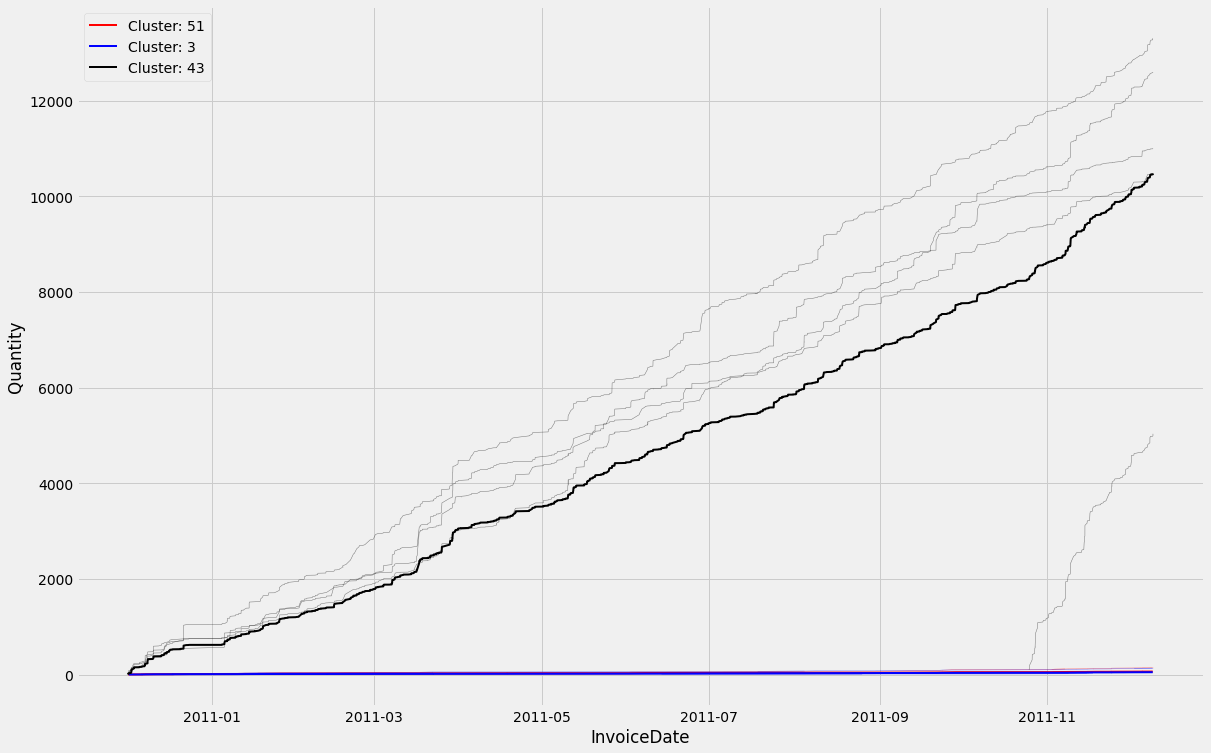

In [22]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))
random_cluster_ids = clusters_center_df['Id'].sample(n = 3, random_state = 40).tolist()
colors = ['red', 'blue', 'black']

# add max to product dfplot
for inx, cluster_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 21.5 s


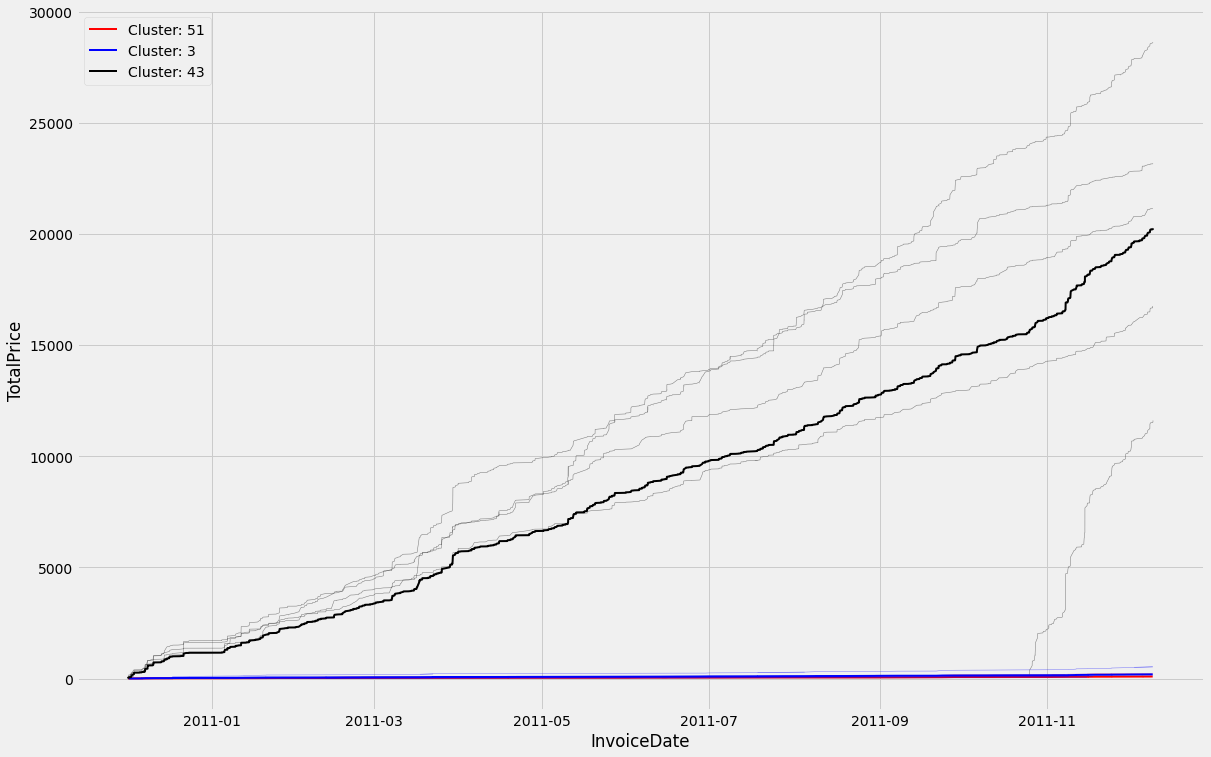

In [23]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 2min 19s


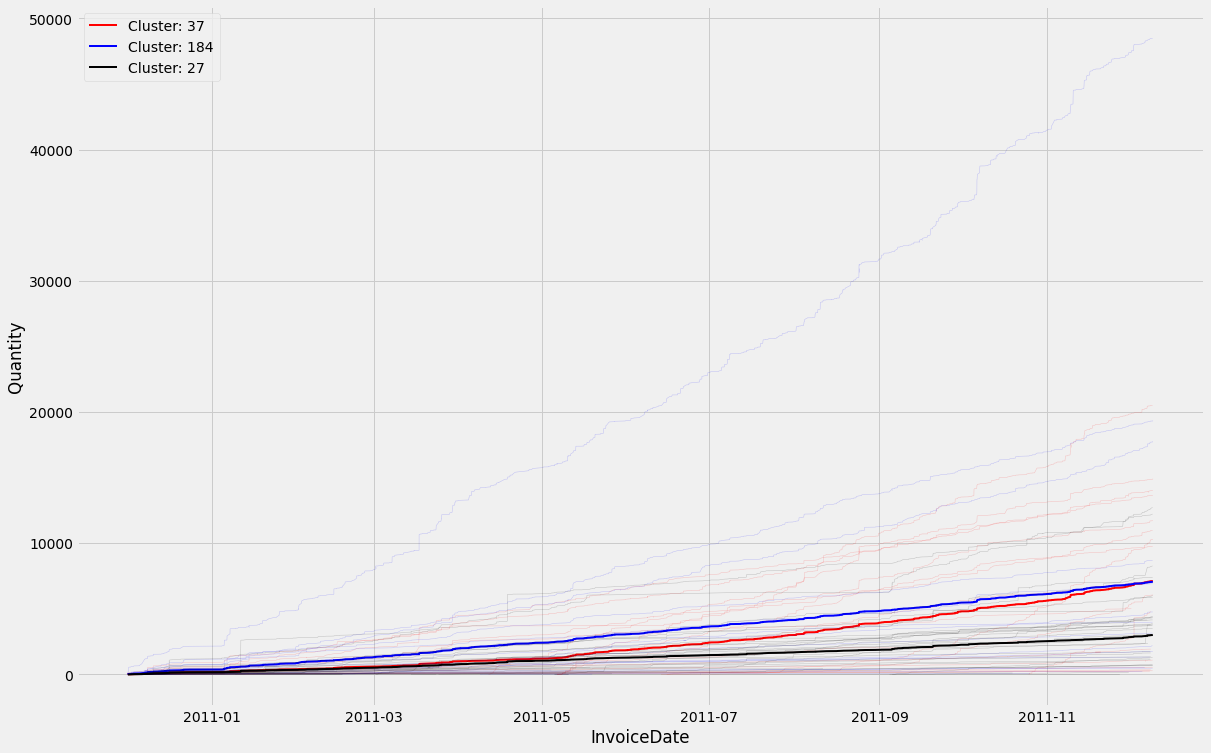

In [24]:
%%time
# @formatter:on

top_quantity_sum_cluster_ids = df.sort_values(by = ['ClusterIdQuantitySum'],
                                              ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_quantity_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 2min 3s


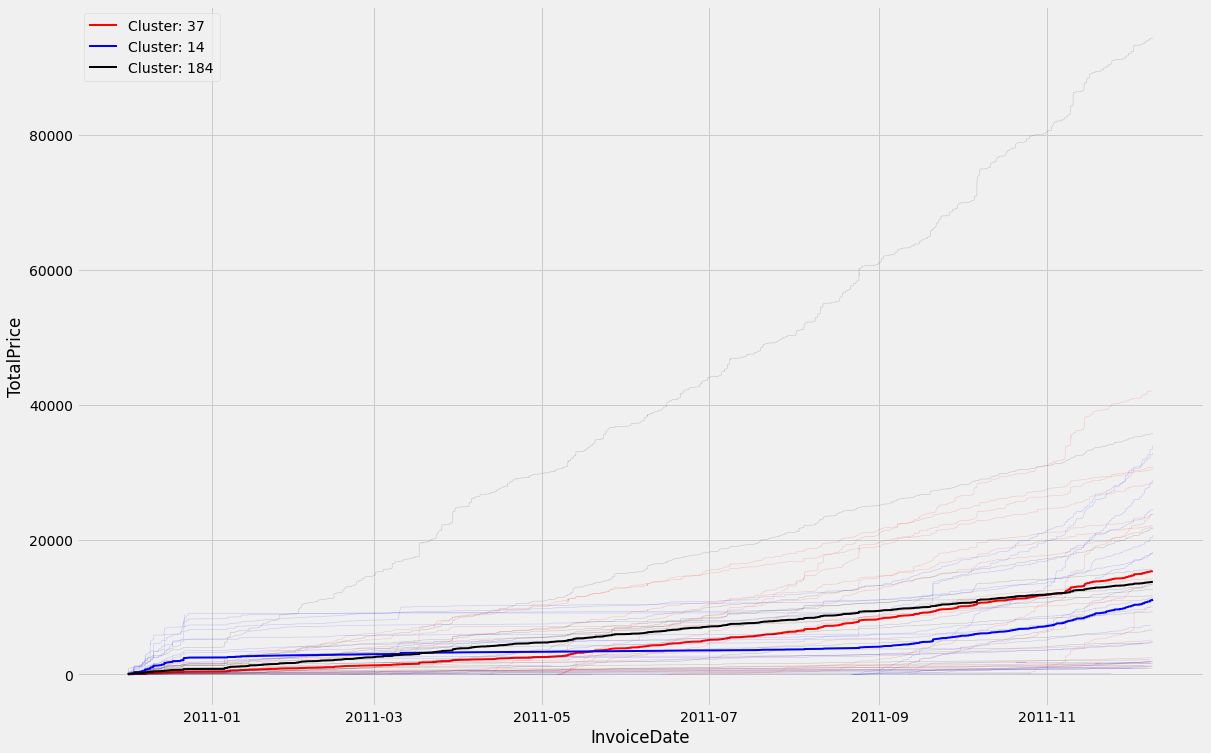

In [25]:
%%time
# @formatter:on

top_total_price_sum_cluster_ids = df.sort_values(by = ['ClusterIdTotalPriceSum'],
                                                 ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_total_price_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])

